Exercise 2: First Model Training

In [20]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
dataset_dir = "~/data"

In [5]:
# Download CIFAR-10 dataset and apply the transformations
trainset = torchvision.datasets.CIFAR10(root= dataset_dir, train= True, download = True, transform = transforms.ToTensor())

# Create a DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 2)

# Get a batch of data to verify that everything is working
# dataiter = iter(trainloader)
images, labels = next(iter(trainloader))

print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels shape: {labels.shape}")
print(f"Possible classes: {','.join(trainset.classes)}")

Batch of images shape: torch.Size([64, 3, 32, 32])
Batch of labels shape: torch.Size([64])
Possible classes: airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck


Plot images in a 8x8 grid to get a sense of what they look like

In [ ]:
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
plt.rcParams.update({'axes.titlesize': 'small'})
plt.tight_layout()
# Remove vertical space
plt.subplots_adjust(hspace=0.25, wspace=0.1)

for i in range(8):
    for j in range(8):
        # Note that we need to change the order of the dimensions.
        # Torch prepare the images to be (C, H, W) but matplotlib expects (H, W, C)
        # (H = height, W = width, C = number of color channels)
        ax[i, j].imshow(images[i*8 + j].permute(1, 2, 0))
        ax[i,j].set_title(trainset.classes[labels[i*8 + j]])
        ax[i,j].axis('off')

Find the mean value and the standard deviation of the images in the dataset

In [10]:
images_mean = trainset.data.mean(axis = (0,1,2))/255
images_std = trainset.data.std(axis = (0,1,2))/255
images_mean, images_std

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [11]:
transform_train_example = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally for the data augmentation
    transforms.RandomCrop(32, padding_mode='reflect', padding=5), # Randomly crop the image for the data augmentation
    transforms.ToTensor(), # Convert the image to a tensor
    transforms.Normalize(mean=images_mean, std=images_std) # Normalize the tensor
])

In [ ]:
viz_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding_mode='reflect', padding=5)
])

im = transforms.ToPILImage()(images[10])
n_transforms = 9

fix, ax = plt.subplots(3, 3, figsize=(4, 4))
for i in range(n_transforms):
    if i == 0: # The first image is the original one
        ax[i//3,i%3].imshow(im)
    else: # The rest are the transformed images
        ax[i//3,i%3].imshow(viz_transform(im))
    ax[i//3,i%3].axis('off')

In [16]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Notes:
        # - Each layer requires specifying the number of input and output features
        # - The first layer takes as input a flattened image (32x32x3) and should produce 512 features
        #   (i.e., it encodes the image into a 512-dimensional space)
        # - The second layer should produce 256 features
        # - The output layer should produce 10 features (these will be the logits)
        self.fc1 = nn.Linear(32*32*3, 512) #  Input layer to first hidden layer
        self.fc2 = nn.Linear(512, 256) # First hidden layer to second hidden layer
        self.fc3 = nn.Linear(256, 10) # Second hidden layer to output layer
        
    def forward(self, x):
        # Notes:
        # - first step: flatten the input (preserve the batch size, flatten the rest)
        # - apply the first linear layer with ReLU activation
        # - apply the second linear layer with ReLU activation
        # - apply the output layer (no activation needed for the output layer)
        x = x.view( -1, 32*32*3) # Flatten the input
        # Apply layers with ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x) # Output layer (no activation needed for the output layer)
        return x

In [17]:
# Define transformations for the training and test datasets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding_mode='reflect', padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [18]:
# Load CIFAR-10 dataset
batch_size = 1024
trainset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root=dataset_dir, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [21]:
# Initialize the model, loss function, and optimizer
model = SimpleNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [22]:
def val_model(model, testloader):
    model.eval() # NOTE: required to set the model to evaluation mode (some layers may behave differently during training and evaluation)
    correct = 0
    total = 0
    with torch.no_grad(): # NOTE: we disable gradient tracking for validation, to save memory!
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy of the network on the test images: {100 * correct / total:.2f}%")

In [ ]:
val_model(model, testloader)

Accuracy of the network on the test images: 10.05%


In [24]:
# Training loop
num_epochs = 5

losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # TODO: let's implement the training loop for the model
        # Notes:
        # - First, zero the parameter gradients
        # - Next, get the model's predictions
        # - Compute the loss
        # - Perform backpropagation (i.e. compute all gradients)
        # - Finally, update the model's parameters

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()


        losses.append(loss.item())

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

Epoch [1/5], Loss: 2.1019
Epoch [2/5], Loss: 1.8670
Epoch [3/5], Loss: 1.7646
Epoch [4/5], Loss: 1.7001
Epoch [5/5], Loss: 1.6577


In [25]:
val_model(model, testloader)

Accuracy of the network on the test images: 45.87%


In [ ]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")

Load and train a Model on CIFAR-10

In [27]:
# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

testset = torchvision.datasets.CIFAR10(root=dataset_dir, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

In [28]:
from torchvision import models

# Load a pre-trained model (ResNet18)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
model = model.to(device)

In [29]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [30]:
# Training loop
num_epochs = 5

losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

Epoch [1/5], Loss: 1.7429
Epoch [2/5], Loss: 1.4015
Epoch [3/5], Loss: 1.2524
Epoch [4/5], Loss: 1.1529
Epoch [5/5], Loss: 1.0780


In [33]:
# Validate the model
val_model(model, testloader)

Accuracy of the network on the test images: 62.97%


Text(0, 0.5, 'Loss')

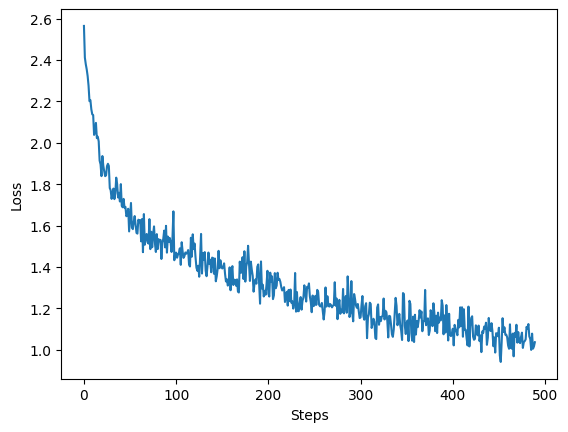

In [34]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")